In [83]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
from scipy.spatial import distance

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
'''
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"\nimport os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

# Using haar cascade to detect faces
Object Detection using Haar feature-based cascade classifiers is an effective object detection method proposed by Paul Viola and Michael Jones in their paper, "Rapid Object Detection using a Boosted Cascade of Simple Features" in 2001. It is a machine learning based approach where a cascade function is trained from a lot of positive and negative images. It is then used to detect objects in other images.
We'll be using a Haar Cascade Model trained to detect faces in order to obtain the bounding box coordinates of faces in an image.

In [84]:
#loading haarcascade_frontalface_default.xml
face_model = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

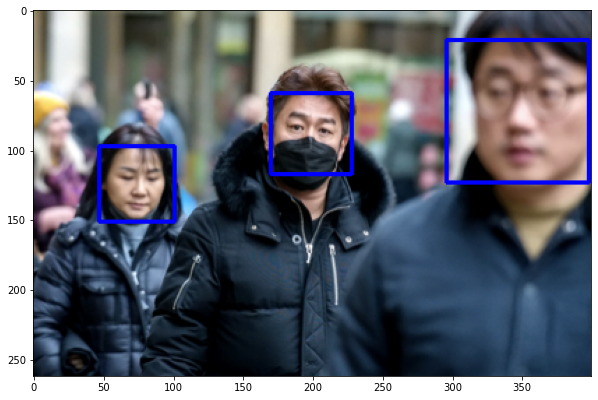

In [85]:
import matplotlib.pyplot as plt
#trying it out on a sample image
img = cv2.imread('train_images/maksssksksss244.png')

img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

faces = face_model.detectMultiScale(img) #returns a list of (x,y,w,h) tuples

out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image

#plotting
for (x,y,w,h) in faces:
    cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,0,255),2)
plt.figure(figsize=(10,10))
plt.imshow(out_img)

# Using mobilenet_v2 for mask detection


In [86]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [87]:
#augmentation
train_dir = 'Face Mask Dataset/Train'
test_dir = 'Face Mask Dataset/Test'
val_dir = 'Face Mask Dataset/Validation'

train_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True,zoom_range = 0.2, shear_range=0.2, brightness_range=[.4,1.5])  
train_generator = train_datagen.flow_from_directory(directory=train_dir,target_size=(200,200),class_mode='categorical', batch_size=32)

val_datagen = ImageDataGenerator(rescale=1.0/255)
val_generator = train_datagen.flow_from_directory(directory=val_dir,target_size=(200,200),class_mode='categorical', batch_size=32)

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = train_datagen.flow_from_directory(directory=test_dir,target_size=(200,200),class_mode='categorical',batch_size=32)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [88]:
mobilenet = MobileNetV2(weights='imagenet',include_top=False,input_shape=(200,200,3))
for layer in mobilenet.layers:
    layer.trainable = False
model = Sequential()
model.add(mobilenet)
model.add(Flatten())
model.add(Dense(2,activation='sigmoid'))
model.summary()

C:\Users\daniel\anaconda3\envs\tf\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 3s 0us/step
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_10 (Flatten)         (None, 62720)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 125442    
Total params: 2,383,426
Trainable params: 125,442
Non-trainable params: 2,257,984
_________________________________________________________________


In [96]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics =["accuracy"])
history = model.fit_generator(generator=train_generator,steps_per_epoch=len(train_generator)//32,epochs=20,validation_data=val_generator,validation_steps=len(val_generator)//32)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 9 steps, validate for 25 steps
Epoch 1/9
9/9 [==============================] - 131s 15s/step - loss: 0.3076 - accuracy: 0.9688 - val_loss: 0.3026 - val_accuracy: 0.9663
Epoch 2/9
9/9 [==============================] - 124s 14s/step - loss: 0.6074 - accuracy: 0.9444 - val_loss: 0.7771 - val_accuracy: 0.9162
Epoch 3/9
9/9 [==============================] - 113s 13s/step - loss: 0.4588 - accuracy: 0.9653 - val_loss: 1.6140 - val_accuracy: 0.8363
Epoch 4/9
9/9 [==============================] - 118s 13s/step - loss: 0.4225 - accuracy: 0.9618 - val_loss: 0.7547 - val_accuracy: 0.9112
Epoch 5/9
9/9 [==============================] - 110s 12s/step - loss: 0.4609 - accuracy: 0.9618 - val_loss: 1.0369 - val_accuracy: 0.9025
Epoch 6/9
9/9 [==============================] - 112s 12s/step - loss: 0.5593 - accuracy: 0.9514 - val_loss: 1.0429 - val_accuracy: 0.9112
Epoch 7/9
9/9 [==============================] - 113s 13s/step - loss: 0.37

In [90]:
model.evaluate_generator(test_generator)

  ...
    to  
  ['...']


[0.33332010574879184, 0.922379]

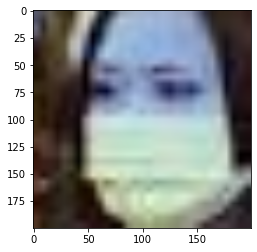

In [91]:
sample_mask_img = cv2.imread('Face Mask Dataset/Test/WithMask/3.png')
sample_mask_img = cv2.resize(sample_mask_img,(200,200))
plt.imshow(sample_mask_img)
sample_mask_img = np.reshape(sample_mask_img,[1,200,200,3])
sample_mask_img = sample_mask_img/255.0

In [92]:
model.predict(sample_mask_img)

array([[1.0000000e+00, 7.0511183e-04]], dtype=float32)

In [93]:
model.save('masknetHD.h5')

# Integrating with haar cascade
We now take crops of the faces detected in the image and use the model trained in the above section to determine whether the individual faces have a mask or not.

In [94]:
mask_label = {0:'MASK',1:'NO MASK'}
dist_label = {0:(0,255,0),1:(255,0,0)}

In [95]:
if len(faces)>=2:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<130:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        crop = new_img[y:y+h,x:x+w]
        crop = cv2.resize(crop,(128,128))
        crop = np.reshape(crop,[1,128,128,3])/255.0
        mask_result = model.predict(crop)
        cv2.putText(new_img,mask_label[mask_result.argmax()],(x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,dist_label[label[i]],2)
        cv2.rectangle(new_img,(x,y),(x+w,y+h),dist_label[label[i]],2)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
            
else:
    print("No. of faces detected is less than 2")

ValueError: Error when checking input: expected mobilenetv2_1.00_224_input to have shape (200, 200, 3) but got array with shape (128, 128, 3)

<h1 align='center'>Thanks for reading</h1>
<div align='center'> for implementation of this code on live cam videos check out <a href="https://github.com/giwilorjelly/AI-Social-Distancing-with-Mask-Detecion"> this repository</a> </div>